# Data Visualization Utilities

Because I should probably start standardizing my data exploration.

In [1]:
import numpy as np
import sys
import os
import pandas as pd
from nltk import word_tokenize
from collections import Counter
from itertools import chain
import matplotlib.pyplot as plt, mpld3
%matplotlib inline
import re

sys.path.append('..')
from imp import reload
from data import reddit_preprocessor, DataHelper
from data.reddit_preprocessor import *
import json
from pprint import pprint
from jupyterthemes import jtplot

jtplot.style('onedork', ticks=True, fscale=1.5)
jtplot.figsize(x=11., y=8.)
DATA_ROOT = '/home/brandon/Datasets/test_data'
FROM = os.path.join(DATA_ROOT, 'train_from.txt')
TO = os.path.join(DATA_ROOT, 'train_to.txt')

In [2]:
COL_NAMES = ['inp_sentence', 'resp_sentence']

def make_dataframe(data_dir):
    """
    data_dir: contains train_from.txt, train_to.txt
    """
    from_lines = []
    to_lines = []
    with open(os.path.join(data_dir, 'train_from.txt'), 'r') as from_file:
        with open(os.path.join(data_dir, 'train_to.txt'), 'r') as to_file:
            from_line = from_file.readline()
            to_line = to_file.readline()
            while from_line and to_line:
                from_lines.append(from_line.strip())
                to_lines.append(to_line.strip())
                from_line = from_file.readline()
                to_line = to_file.readline()
            df = pd.DataFrame(np.stack((from_lines, to_lines), 1),
                              columns=COL_NAMES)        
        return df
    
def word_tokenize(df):
    word_freq = {}
    
    # I know. I KNOW.
    sentences = np.squeeze(list(((map(
        DataHelper.word_tokenizer, 
        list(np.expand_dims(df[COL_NAMES[0]].values, 1)))))))
    
    word_freq['from'] = Counter(chain.from_iterable(sentences))
    # Stop judging me.
    sentences = np.squeeze(list(((map(
        DataHelper.word_tokenizer, 
        list(np.expand_dims(df[COL_NAMES[1]].values, 1)))))))
    word_freq['to'] = Counter(chain.from_iterable(sentences))
    
    return word_freq

def plot_freq_dist(word_freq, n):
    words_dict = {}
    for dist in word_freq:
        most_comm = word_freq[dist].most_common(n)
        words, counts = zip(*most_comm)
        words_dict[dist] = words
        counts_series = pd.Series.from_array(counts)

        plt.figure(figsize=(8, 5))
        ax = counts_series.plot(kind='bar')

        ax.set_title('Frequency Distribution: ' + dist)
        ax.set_ylabel('Counts')
        ax.set_xlabel('Words')
        ax.set_xticklabels(words_dict[dist])

    from_words = set(words_dict['from'])
    to_words = set(words_dict['to'])
    common_words = from_words.intersection(to_words)
    common_word_freqs = [
        [word_freq['from'][w] for w in common_words],
        [word_freq['to'][w] for w in common_words]]
    
    ind = np.arange(len(common_words))
    plt.figure(figsize=(8, 5))
    p1 = plt.bar(ind, common_word_freqs[0], width=0.5, color='b')
    p2 = plt.bar(ind, common_word_freqs[1], width=0.5, color='r')
    plt.xticks(ind, common_words)
    plt.legend((p1[0], p2[0]), ('From', 'To'))
    return common_words

In [3]:
pd.set_option('display.max_colwidth', 10000)
df = make_dataframe(DATA_ROOT)

In [ ]:
pd.set_option('display.max_colwidth', 10000)
df.head(len(df.index))

In [ ]:
word_freq = word_tokenize(df)

In [ ]:
common_words = plot_freq_dist(word_freq, 5)

In [ ]:
common_words

# From TensorBoard to JSON to Matplotlib

In [2]:
import os
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
from scipy.interpolate import spline
jtplot.style('onedork', ticks=True, fscale=1.5)
jtplot.figsize(x=11., y=8.)
pd.set_option('display.max_colwidth', 1000)

# --------------------------------------------------------
# Globals
# --------------------------------------------------------
PROJECT_ROOT = os.getenv('SEQ')
BASE_DIR = 'json_data'
ACC_DIR = os.path.join(BASE_DIR, 'accuracy_json')
TRAIN_DIR = os.path.join(BASE_DIR, 'train_loss_json')
VALID_DIR = os.path.join(BASE_DIR, 'valid_loss_json')
COL_NAMES =  ['wall_time', 'iteration']

# TODO: this should be determined by scanning filenames, not hardcoded.
run_keys = ['sota', 'basicAttention', 'deep', 'talkativeGRU']

df_acc = {}
df_train = {}
df_valid = {}
configs = {}

for k in run_keys:
    fname = 'run-'+k+'-tag-evaluation_accuracy.json'
    df_acc[k] = pd.read_json(os.path.join(ACC_DIR, fname))
    
    fname = 'run-'+k+'-tag-evaluation_loss_train.json'
    df_train[k] = pd.read_json(os.path.join(TRAIN_DIR, fname))
    
    fname = 'run-'+k+'-tag-evaluation_loss_valid.json'
    df_valid[k] = pd.read_json(os.path.join(VALID_DIR, fname))
    
    fname = os.path.join(PROJECT_ROOT, 'out/cornell', k, 'config.yml')
    with open(fname, 'r') as config_file:
        configs[k] = yaml.load(config_file)
    
    df_acc[k].columns = COL_NAMES + ['accuracy']
    df_train[k].columns = COL_NAMES + ['training loss']
    df_valid[k].columns = COL_NAMES + ['validation loss']

In [14]:
def plot_df(df, y_name, run_key):
    """Assuming df is from tensorboard json . . . """
    iters = df.iteration
    iters_new = np.linspace(iters.min(), iters.max(), 50)
    smooth_y = spline(iters, df[y_name], iters_new)
    plt.plot(iters_new, smooth_y, label=run_key)
    plt.title(y_name.title())
    plt.ylabel(y_name)
    if y_name == 'accuracy':
        plt.ylim([0., 1.])
    plt.xlabel('Iteration')
    plt.legend(loc='upper right')

def plot_runs(df_dict, y_name):
    """Calls plot_df for each key in the df_dict."""
    fig = plt.figure(figsize=(8, 5))
    for k in run_keys:
        plot_df(df_dict[k], y_name, k)
    return fig


Note: if you're in the IPython notebook, mpld3.show() is not the best command
      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
      See more information at http://mpld3.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [08/May/2017 18:42:53] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [08/May/2017 18:42:54] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [08/May/2017 18:42:54] "GET /mpld3.js HTTP/1.1" 200 -



stopping Server...


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


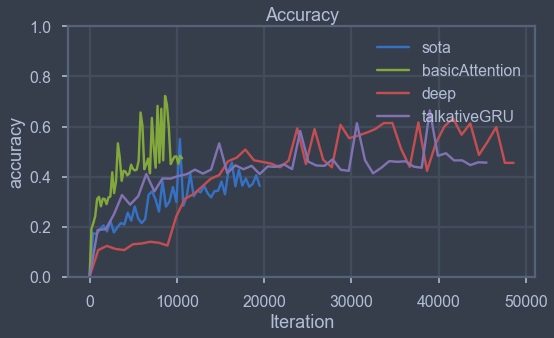

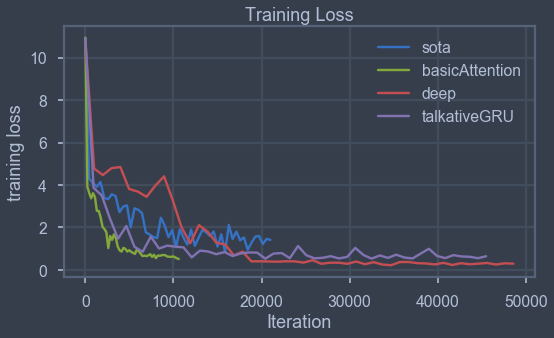

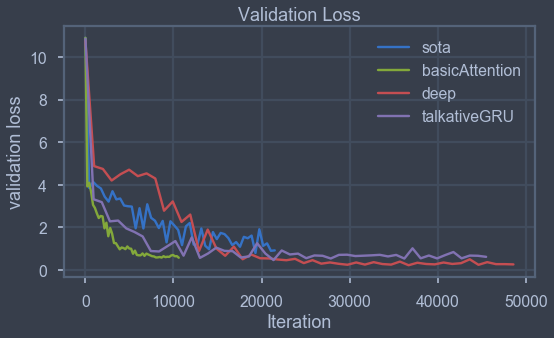

In [15]:
jtplot.style('onedork', ticks=True, context='poster', fscale=1.5)
acc_fig = plot_runs(df_acc, 'accuracy')
train_fig = plot_runs(df_train, 'training loss')
valid_fig = plot_runs(df_valid, 'validation loss')
plt.show()

In [30]:
html_dir = os.path.join(os.getenv('STATIC'), 'assets/plots')
for fname, fig in {'accuracy': acc_fig, 'training': train_fig, 'validation': valid_fig}.items():
    with open(os.path.join(html_dir, fname+'.json'), 'w') as f:
        mpld3.save_json(fig, f)

In [29]:
print('uhhh')

uhhh


In [14]:
for k in run_keys:
    print(k.upper())
    print('\t', configs[k]['model_params']['encoder.class'], ' ',
          configs[k]['model_params']['decoder.class'], sep='')
    print('\tBatch size:', configs[k]['model_params']['batch_size'])
    print('\tNum layers:', configs[k]['model_params']['num_layers'])
    print('\tVocab size:', configs[k]['dataset_params']['vocab_size'])
    print('\tMax seq len:', configs[k]['dataset_params']['max_seq_len'])

SOTA
	BidirectionalEncoder AttentionDecoder
	Batch size: 128
	Num layers: 1
	Vocab size: 52000
	Max seq len: 20
BASICATTENTION
	BasicEncoder AttentionDecoder
	Batch size: 256
	Num layers: 1
	Vocab size: 52000
	Max seq len: 10
DEEP
	chatbot.components.encoders.BasicEncoder chatbot.components.decoders.BasicDecoder
	Batch size: 256
	Num layers: 3
	Vocab size: 45000
	Max seq len: 15
TALKATIVEGRU
	BasicEncoder BasicDecoder
	Batch size: 256
	Num layers: 1
	Vocab size: 50000
	Max seq len: 20
